<div style="color:white;
           display:fill;
           border-radius:5px;
           background-color:#5642C5;
           font-size:200%;
           font-family:Arial;letter-spacing:0.5px">

<p width = 20%, style="padding: 10px;
              color:white;">
K Nearest Neighbors and the Curse of Dimensionality
              
</p>
</div>

Data Science Cohort Live NYC Feb 2022
<p>Phase 3: Topic 26</p>
<br>
<br>

<div align = "right">
<img src="Images/flatiron-school-logo.png" align = "right" width="200"/>
</div>
    
    

In [58]:
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

<center><img src = "Images/neighbor_tyranny.jpg" width = 450/></center>

<center>There's truth here. But we can also rely on this tyranny to help us build classifiers.</center>

<center> Let's do it. </center>

#### K-nearest neighbors

**Process of predicting in k-nearest algorithm**

Take a **test** data point, look at it's $k$ nearest neighbors in **training** set:

- Look at what class neighbors in training set all are.
- Count class tallies all up.
- Assign datapoint to winning majority class.

<center><img src = "Images/knn_3.webp" width = 800/></center>
<center> k = 3 neighbors </center>

- Concept is easy. 
- Doing this efficiently: exercise in algorithms and data structures.


More details:

https://towardsdatascience.com/tree-algorithms-explained-ball-tree-algorithm-vs-kd-tree-vs-brute-force-9746debcd940


**Process of training k-nearest algorithm**

- Store the training data points.
- Yeah thats it.

#### The role of $k$: number of neighbors

<img src = "Images/KNN_nearestnn.png" width = 400 />

Changing neighbors:
- Clearly affects which KNN predicts for test point.

- Lower $k$ implies higher sensitivity to fluctuations
- E.g. two green points as fluctuation at $k = 3$

**Low $k$ = higher variance**

If $k$ increases too much:
- Always predicts majority class in training set.
- Model too "rigid"
- Not sensitive enough to relationship between target and features

<img src = "Images/knn_neighbor_increase.jpeg" width = 600 />

Too high $k$ means high bias.

In summary:
<center><img src = "Images/bias_variance.png" /></center>

#### Before we even think about running this or any distance-based model

<center>SCALE THE FEATURES!!!</center>

Otherwise: 
- Weights distances in different feature dimension differently
- Obviously no good.

<center><img src = "Images/nonnormal.png" /></center>
<center>Unscaled</center>

<center><img src = "Images/normalized.png" /></center>
<center>Scaled</center>

Run KNN classifier on a dataset and tune hyperparameters:
- Load that iris dataset.

In [59]:
iris_df = pd.read_csv('Data/Iris.csv').drop(columns = ['Id'])
iris_df.head()

,SepalLengthCm,SepalWidthCm,PetalLengthCm,PetalWidthCm,Species
0,5.1,3.5,1.4,0.2,Iris-setosa
1,4.9,3.0,1.4,0.2,Iris-setosa
2,4.7,3.2,1.3,0.2,Iris-setosa
3,4.6,3.1,1.5,0.2,Iris-setosa
4,5.0,3.6,1.4,0.2,Iris-setosa


In [60]:
from sklearn.preprocessing import LabelEncoder
target_transform = LabelEncoder()
iris_df['Species'] = target_transform.fit_transform(iris_df['Species'])

In [61]:
iris_df['Species']

0      0
1      0
2      0
3      0
4      0
      ..
145    2
146    2
147    2
148    2
149    2
Name: Species, Length: 150, dtype: int32

- What next steps should we take?

Visualize the data.

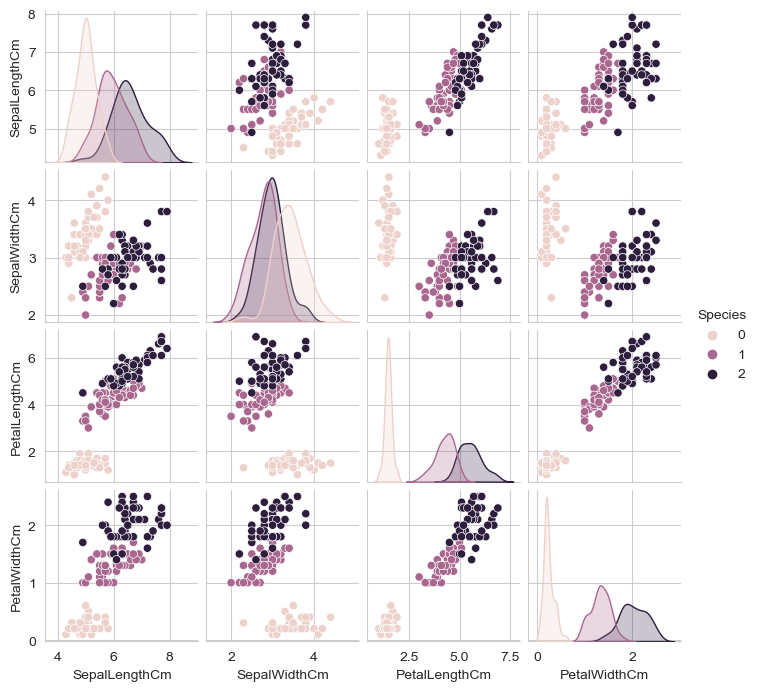

In [62]:
sns.pairplot(hue = 'Species', data = iris_df, height = 1.75)
plt.show()

For instruction sake let's do classification with following two features:
- sepal width
- petal width

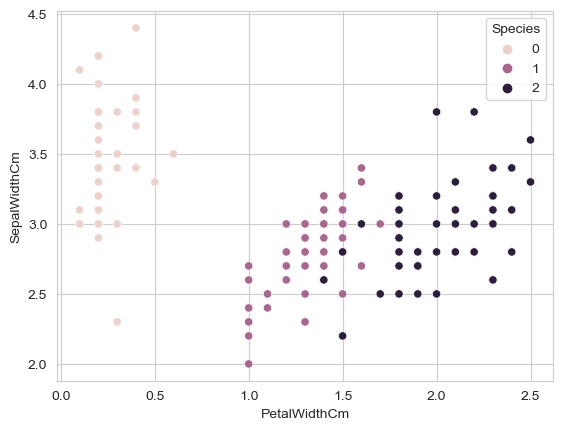

In [63]:
sns.scatterplot(y = 'SepalWidthCm', x = 'PetalWidthCm', hue = 'Species', data = iris_df)
plt.show()

Some overlap between class 1 and 2:
- Virginica
- Versicolor

What next?

1. Separate dataframe into X (features) and y (labels)
2. Train/test split

In [64]:
# so whats next?
X = iris_df[['SepalWidthCm', 'PetalWidthCm']]
y = iris_df['Species']

In [65]:
# shuffle and split, stratify keeps target distribution same in train/test
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify = y, test_size = 0.15, random_state = 42)

Now we standardize features, right?

Depends!
- If doing simple train/test split, then yes!
- If doing cross-validation, then no!

Mess around with $k$:
- Look at performance
- Hyperparameter tune/cross-validate

So we won't fit the standardizer on the entire training set.

In [66]:
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

In [67]:
def cross_validation(X_train, y_train, k, num_split = 10):
    
    X_train = X_train.values
    y_train = y_train.values
    
    score_train_list = []
    score_val_list = []
    
    for train_index, valid_index in KFold(n_splits = num_split).split(X_train):


        # train and validation splitting 
        X_train_fold, X_val_fold = X_train[train_index], X_train[valid_index]
        y_train_fold, y_val_fold = y_train[train_index], y_train[valid_index]

        #create/fit the Standard scaler on the train fold
        scaler = StandardScaler()
        X_tf_sc = scaler.fit_transform(X_train_fold)
        # transform validation fold
        X_vld_sc = scaler.transform(X_val_fold)

        # create/fit knearest neighbor
        knn = KNeighborsClassifier(n_neighbors = k)
        knn.fit(X_tf_sc, y_train_fold)
        
        # now how did we do?
        accuracy_train = knn.score(X_tf_sc, y_train_fold)
        accuracy_val = knn.score(X_vld_sc, y_val_fold)
        score_val_list.append(accuracy_val)
        score_train_list.append(accuracy_train)
    
    return {'k': k, 'train': np.mean(score_train_list), 'validation': np.mean(score_val_list)}

In [68]:
# empty dataframe
crossval_df = pd.DataFrame(columns = ['k', 'train', 'validation'])
# append results for each value of k
for k in np.arange(1,100):
    crossval_df = crossval_df.append(cross_validation(X_train, y_train, k, 5), ignore_index = True)

C:\Users\pedro\AppData\Local\Temp\ipykernel_17888\1252391055.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  crossval_df = crossval_df.append(cross_validation(X_train, y_train, k, 5), ignore_index = True)
C:\Users\pedro\AppData\Local\Temp\ipykernel_17888\1252391055.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  crossval_df = crossval_df.append(cross_validation(X_train, y_train, k, 5), ignore_index = True)
C:\Users\pedro\AppData\Local\Temp\ipykernel_17888\1252391055.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  crossval_df = crossval_df.append(cross_validation(X_train, y_train, k, 5), ignore_index = True)
C:\Users\pedro\AppData\Local\Temp\ipykernel_17888\1252391055.py:5: FutureWarning: The frame.append method 

In [69]:
crossval_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99 entries, 0 to 98
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   k           99 non-null     float64
 1   train       99 non-null     float64
 2   validation  99 non-null     float64
dtypes: float64(3)
memory usage: 2.4 KB


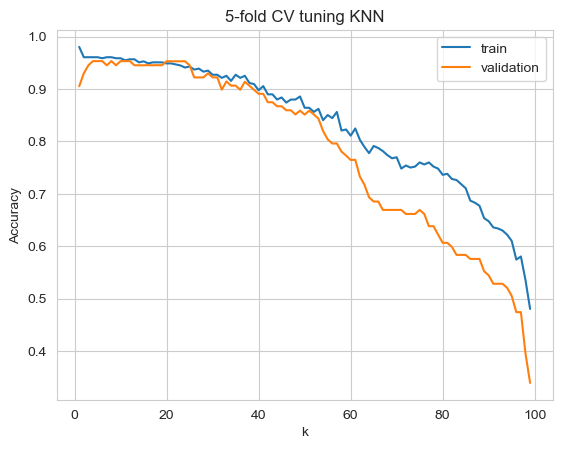

In [70]:
fig, ax = plt.subplots()
sns.lineplot(x = 'k', y = 'train', 
             data = crossval_df, 
             ax = ax, label = 'train')
sns.lineplot(x = 'k', y = 'validation', 
             data = crossval_df,
             ax = ax, label = 'validation')
ax.set_ylabel('Accuracy')
ax.set_title('5-fold CV tuning KNN')
plt.show()

Some bias-variance tradeoff in action as a function of $k$.

In [71]:
# let's find our best performing k-value
crossval_df.iloc[crossval_df['validation'].idxmax()]

k             4.000000
train         0.960629
validation    0.953231
Name: 3, dtype: float64

So we determined best estimator at $k = 4$:
- Fit the full train set with estimator at this value of $k$.
- Evaluate performance on true test/hold-out.

In [72]:
fulltrain_scaler = StandardScaler()
X_train_sc = fulltrain_scaler.fit_transform(X_train)
X_test_sc = fulltrain_scaler.transform(X_test)

best_estimator = KNeighborsClassifier(n_neighbors = 4)
best_estimator.fit(X_train_sc, y_train)

# get predictions
y_pred = best_estimator.predict(X_test_sc)

In [73]:
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import classification_report

In [74]:
plot_confusion_matrix(best_estimator, X_test_sc, y_test)

C:\Users\pedro\anaconda3\Lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


In [75]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00         7
           1       0.88      0.88      0.88         8
           2       0.88      0.88      0.88         8

    accuracy                           0.91        23
   macro avg       0.92      0.92      0.92        23
weighted avg       0.91      0.91      0.91        23



In 2D feature space: 
- visualize decision boundary
- prediction space vs. actual data

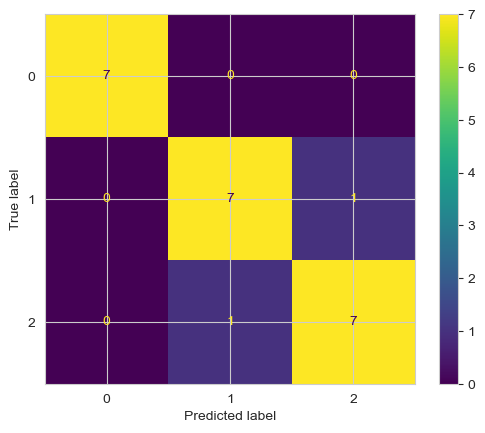

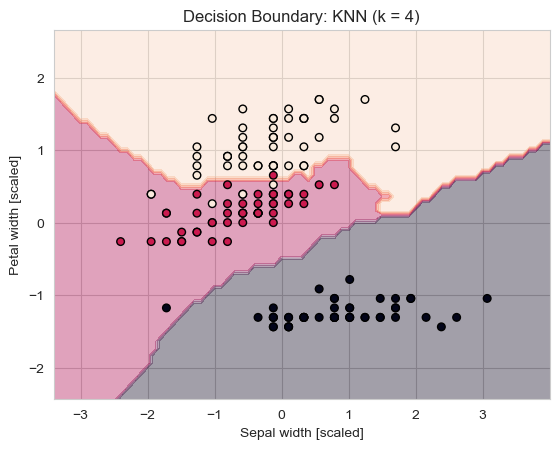

In [76]:
X_full_sc = fulltrain_scaler.transform(X)
x_min, x_max = X_full_sc[:, 0].min() - 1, X_full_sc[:, 0].max() + 1
y_min, y_max = X_full_sc[:, 1].min() - 1, X_full_sc[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1), np.arange(y_min, y_max, 0.1))

f, ax = plt.subplots()

Z = best_estimator.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)
ax.contourf(xx, yy, Z, alpha=0.4)
ax.scatter(X_full_sc[:, 0], X_full_sc[:, 1], c = y, s=30, edgecolor="k")
ax.set_xlabel('Sepal width [scaled]')
ax.set_ylabel('Petal width [scaled]')
ax.set_title('Decision Boundary: KNN (k = 4)')
plt.show()

This is pretty decent and not too bad on the overfitting:
- Given small dataset size
- Some irregularities in decision boundary 
- Validation score as a function of $k$
    - Consider increasing $k$ a little.

#### The effectiveness of the KNN classifier

- Naturally learns complex boundaries.
- KNN can be prone to overfitting


**Another less obvious point:**
- Performance scales badly as the number of features get big.


Let's see why

Take points in 2D:

<img src = "Images/1dto2D_CoD.gif" width = 500/>
<center> Same number of points denser in 1D. </center>

Extend 2D to 3D:
- Number of points fixed.
- Random z-position selection within the cube.


<img src = "Images/2dto3d_CoD.gif" width = 500/>
<center> The density now?</center>

Extend 3D to 4D (add time dimension):
- Snapshots = 3D cross-section of 4D-cube.

Visualize from 1D to 4D.

<img src = "Images/CoD.gif" />

As my dimensionality increases:

- Neighbors get sparse.
- volume scales **exponentially** with number of features.

Being more systematic:

Volume of sphere in $M$ dimensions:

$$ V_M(R) = \frac{\pi^{M/2}}{\Gamma(\frac{M}{2} + 1)}R^M $$

In [77]:
from scipy.special import gamma

def sphere_calc(m, R):
    numerator = (R**m * np.pi**(m/2))
    denom = gamma(m/2 + 1)
    
    return numerator/denom

dim_list = pd.Series(np.arange(1,21))
sph_vol_list = dim_list.map(lambda M: sphere_calc(M, 2)) # get +- 2 std of standardized variables

Now if I have moderate sized dataset of $N = 5000$ points:
- After variable standardization: ~ $\pm 2 \sigma$
- Sphere of radius 2.
- Let's see how the density scales: $$ \rho = \frac{N}{V_M(2)} $$

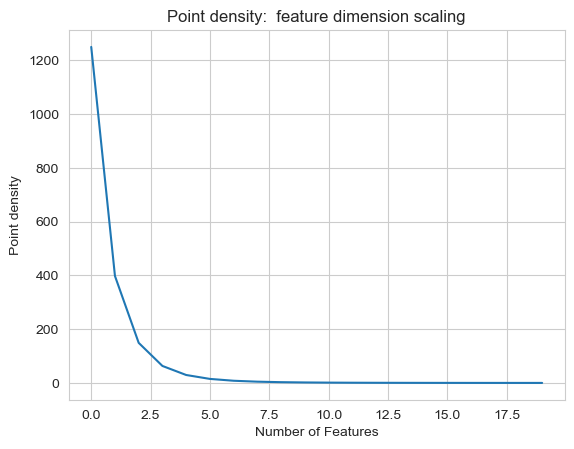

In [78]:
density_vs_dim = 5000/sph_vol_list
fig, ax = plt.subplots()
sns.lineplot(x = density_vs_dim.index, y = density_vs_dim.values, ax = ax)
ax.set_ylabel('Point density')
ax.set_xlabel('Number of Features')
ax.set_title('Point density:  feature dimension scaling')
plt.show()

Life is a lonely place at high dimension:
- Unlikely to have a neighbor within unit sphere at moderate to high dimensions


In [79]:
density_vs_dim.head(10)

0    1250.000000
1     397.887358
2     149.207759
3      63.325740
4      29.683941
5      15.117907
6       8.267605
7       4.812179
8       2.960618
9       1.914705
dtype: float64

This affects all algorithms in small to mid-size problems:
- Need good statistical sampling in feature space for training
- Dataset become sparse in high dimension. Hard to do statistical learning.

**Local, distance based algorithms are especially affected by high D**
- Classification built off point-by-point local consideration.
- Nearest neighbors of a given point: very far away in feature space.
- For each point: unreasonable to rely on tyranny of neighbors.

Majority voting with KNN: starts to be a bad idea.

**Solution**: Dimensionality reduction techniques (will talk about later).